# MACS205 - ODE project

Philippe Sarotte, Titouan Mendiharat, Hippolyte Giraud, Romain Darous.

## 1. Computing the derivative function of the Cauchy problem

In [2]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer
sns.set()

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Initial conditions
Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)


# Fossil fuels
FossFuelData = np.array([[50.0, 0.00], [75.0, 0.30], [100.0, 0.60], [125.0, 1.35], [150.0, 2.85], [175.0, 4.95], [200.0, 7.20], [225.0, 10.05], [250.0, 14.85], [275.0, 20.70], [300.0, 30.00]])
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative


## 2. Implementing several ODE resolution methods

### Euler's methods
It is the Runge Kutta's method for q = 1

In [4]:
def euler_method(f : 'function', y0 : 'np.array', t0 : float, T : float, N : int) :
    time = np.linspace(t0, t0 + T, N)
    y = np.zeros((N, len(y0) ))

    y[0] = y0
    
    h = time[1:] - time[:-1]
    for n in range (N-1) :
        y[n+1] = y[n] + h[n] * f(y[n], time[n])
    return time, y

### Runge-Kutta's method for q = 2

In [5]:
# alpha = 1/2, beta = 1 : midpoint method
# alpha = 1, beta = 1/2 : Heun method

def runge_kutta_two(f : 'function', y0 : 'np.array', t0 : float, T : float, 
                             N : int, alpha : float, beta : float) :
    
    q = 2
    time = np.linspace(t0, t0 + T, N)
    y = np.zeros((N, len(y0)))
    
    y[0] = y0

    h = time[1:] - time[:-1]

    a = np.array([
        [0, 0],
        [alpha, 0]
    ])
    b = np.array([1 - beta, beta])
    c = np.array([0, alpha])

    for n in range(N-1) :
        t_n = time[n] + h[n] * c
        p_n = np.zeros((q, y0.shape[0]))
        y_n = np.zeros((q, y0.shape[0]))

        # i = 0
        p_n[0] = f(y[n], time[n])
        y_n[0] = y[n]

        # i = 1
        y_n[1] = y[n] + h[n] * (a[1,:0] @ p_n[:0])
        p_n[1] = f(y_n[1], t_n[1])
            
        y[n+1] = y[n] + h[n] * (b @ p_n)

    return time, y


### Runge-Kutta's method for q = 3

In [6]:
def runge_kutta_three(f : 'function', y0 : 'np.array', t0 : float, T : float, N : int) :
    q = 3
    time = np.linspace(t0, t0 + T, N)
    a = np.array([
        [0, 0, 0],
        [1/2, 0, 0],
        [0, 1, 0]
    ])
    b = np.array([1/6, 2/3, 1/6])
    c = np.array([0, 1/2, 1])
    h = time[1:] - time[:-1]
    y = np.zeros((N, len(y0) ))
   
    y[0] = y0

    for n in range(N-1) :
        t_n = time[n] + h[n] * c
        p_n = np.zeros((q, y0.shape[0]))
        y_n = np.zeros((q, y0.shape[0]))

       # i = 0
        y_n[0] = y[n]
        p_n[0] = f(y[n], time[n])

       # i > 0
        for i in range(1, 3) :
            y_n[i] = y[n] + h[n] * (a[i,:i-1] @ p_n[:i-1])
            p_n[i] = f(y_n[i], t_n[i])
        
        y[n+1] = y[n] + h[n] * (b @ p_n)
       

    return time, y

### Runge-Kutta's method for q = 4

In [7]:
def runge_kutta_four(f : 'function', y0 : 'np.array', t0 : float, T : float, N : int) :
    q = 4
    time = np.linspace(t0, t0 + T, N)
    
    a = np.array([
        [0, 0, 0, 0],
        [1/2, 0, 0, 0],
        [0, 1/2, 0, 0],
        [0, 0, 1, 0]
    ])

    b = np.array([1/6, 2/6, 2/6, 1/6])
    c = np.array([0, 1/2, 1/2, 1])
    h = time[1:] - time[:-1]
    y = np.zeros((N, len(y0) ))
   
    y[0] = y0

    for n in range(N-1) :
       t_n = time[n] + h[n] * c
       p_n = np.zeros((q, y0.shape[0]))
       y_n = np.zeros((q, y0.shape[0]))

       # i = 0
       y_n[0] = y[n]
       p_n[0] = f(y[n], time[n])

       # i > 0
       for i in range(1, 4) :
           y_n[i] = y[n] + h[n] * (a[i,:i-1] @ p_n[:i-1])
           p_n[i] = f(y_n[i], t_n[i])
        
       y[n+1] = y[n] + h[n] * (b @ p_n)
       

    return time, y

### Runge-Kutta's method for q = 5

In [8]:
def runge_kutta_5(f : 'function', y0 : 'np.array', t0 : float, T : float, N : int) :
    q = 5
    time = np.linspace(t0, t0 + T, N)
    a = np.array([
        [0, 0, 0,0,0],
        [1/2, 0, 0,0,0],
        [0, 1/2, 0,0,0],
        [0,0,1,0,0],
        [0,0,0,1,0]
    ])
    b = np.array([1/6, 2/6, 2/6,1/12,1/12])
    c = np.array([0, 1/2, 1/2,1,1])
    h = time[1:] - time[:-1]
    y = np.zeros((N, len(y0) ))
   
    y[0] = y0

    for n in range(N-1) :
        t_n = time[n] + h[n] * c
        p_n = np.zeros((q, y0.shape[0]))
        y_n = np.zeros((q, y0.shape[0]))

       # i = 0
        y_n[0] = y[n]
        p_n[0] = f(y[n], time[n])

       # i > 0
        for i in range(1, 5) :
            y_n[i] = y[n] + h[n] * (a[i,:i-1] @ p_n[:i-1])
            p_n[i] = f(y_n[i], t_n[i])
        
        y[n+1] = y[n] + h[n] * (b @ p_n)
       

    return time, y

## 3. Plotting resolution of the Cauchy problem using all the methods

We also plot the result given by the built-in Python method ``scipy.integrate.odeint``.

In [9]:
# function solving all the methods
def solve_all_methods(derivative, x0, t0, T, N) :

    time = np.linspace(t0, T, N)
    methods = []
    method_names = []
    exec_time = []

    ### Euler_method
    start_time = timer()
    time, y_euler = euler_method(derivative, x0, t0, T, N)
    end_time = timer()
    
    methods.append(y_euler)
    method_names.append("Euler's method")
    exec_time.append(end_time - start_time)


    ### Runge-Kutta methods

    ## q = 2
    alpha, beta = 1/2, 1
    start_time = timer()
    time, y_rk_two_midpoint = runge_kutta_two(derivative, x0, t0, T, N, alpha, beta)
    end_time = timer()


    methods.append(y_rk_two_midpoint)
    method_names.append('RK Midpoint method (q = 2)')
    exec_time.append(end_time - start_time)

    alpha, beta = 1, 1/2
    start_time = timer()
    time, y_rk_two_heun = runge_kutta_two(derivative, x0, t0, T, N, alpha, beta)
    end_time = timer()
    
    methods.append(y_rk_two_heun)
    method_names.append('RK Heun method (q = 2)')
    exec_time.append(end_time - start_time)

    ## q=3 
    start_time = timer()
    time, y_rk_three = runge_kutta_three(derivative, x0, t0, T, N)
    end_time = timer()

    methods.append(y_rk_three)
    method_names.append('RK method (q = 3)')
    exec_time.append(end_time - start_time)

    ## q = 4
    start_time = timer()
    time, y_rk_four = runge_kutta_four(derivative, x0, t0, T, N)
    end_time = timer()

    methods.append(y_rk_four)
    method_names.append('RK method (q = 4)')
    exec_time.append(end_time - start_time)

    ## q = 5 
    start_time = timer()
    time, y_rk_five = runge_kutta_5(derivative, x0, t0, T, N)
    end_time = timer()

    methods.append(y_rk_five)
    method_names.append('RK method (q = 5)')
    exec_time.append(end_time - start_time)

    ### odeint
    start_time = timer()
    y_odeint = si.odeint(derivative, x0, t = time)
    end_time = timer()

    methods.append(y_odeint)
    method_names.append('OdeInt\'s method')
    exec_time.append(end_time - start_time)

    return methods, method_names, time, exec_time

In [10]:
# initial conditions
x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])
t0 = 0
T = 750
N = 5000

methods, method_names, time, exec_time = solve_all_methods(derivative, x0, t0, T, N)

c:\Users\romai\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Now, for each method, we compute the fonction ``Fossil Fuel Combustion``, as it depends on the ``Fossil Fuel Carbon`` function computed through the ODE solving.

In [11]:
# Computing Fossile Fuel Combustion
def fossilFuelsCombustionArray(fossilFuelCarbon : 'np.array', time : 'np.array') :
    y_fossilFuelsCombustion = []
    for i in range(len(fossilFuelCarbon)) :
        if fossilFuelCarbon[i] > 0:
            y_fossilFuelsCombustion.append(FossilFuelsCombustion(time[i]))
        else:
            y_fossilFuelsCombustion.append(0)
    return np.array(y_fossilFuelsCombustion)

# getting all FossilFuelsCombustion graphs
allFossilFuelsCombustion = [fossilFuelsCombustionArray(methods[a][:,3], time) for a in range(len(methods))]


Let's plot the results for an arbitrary value of ``N``.

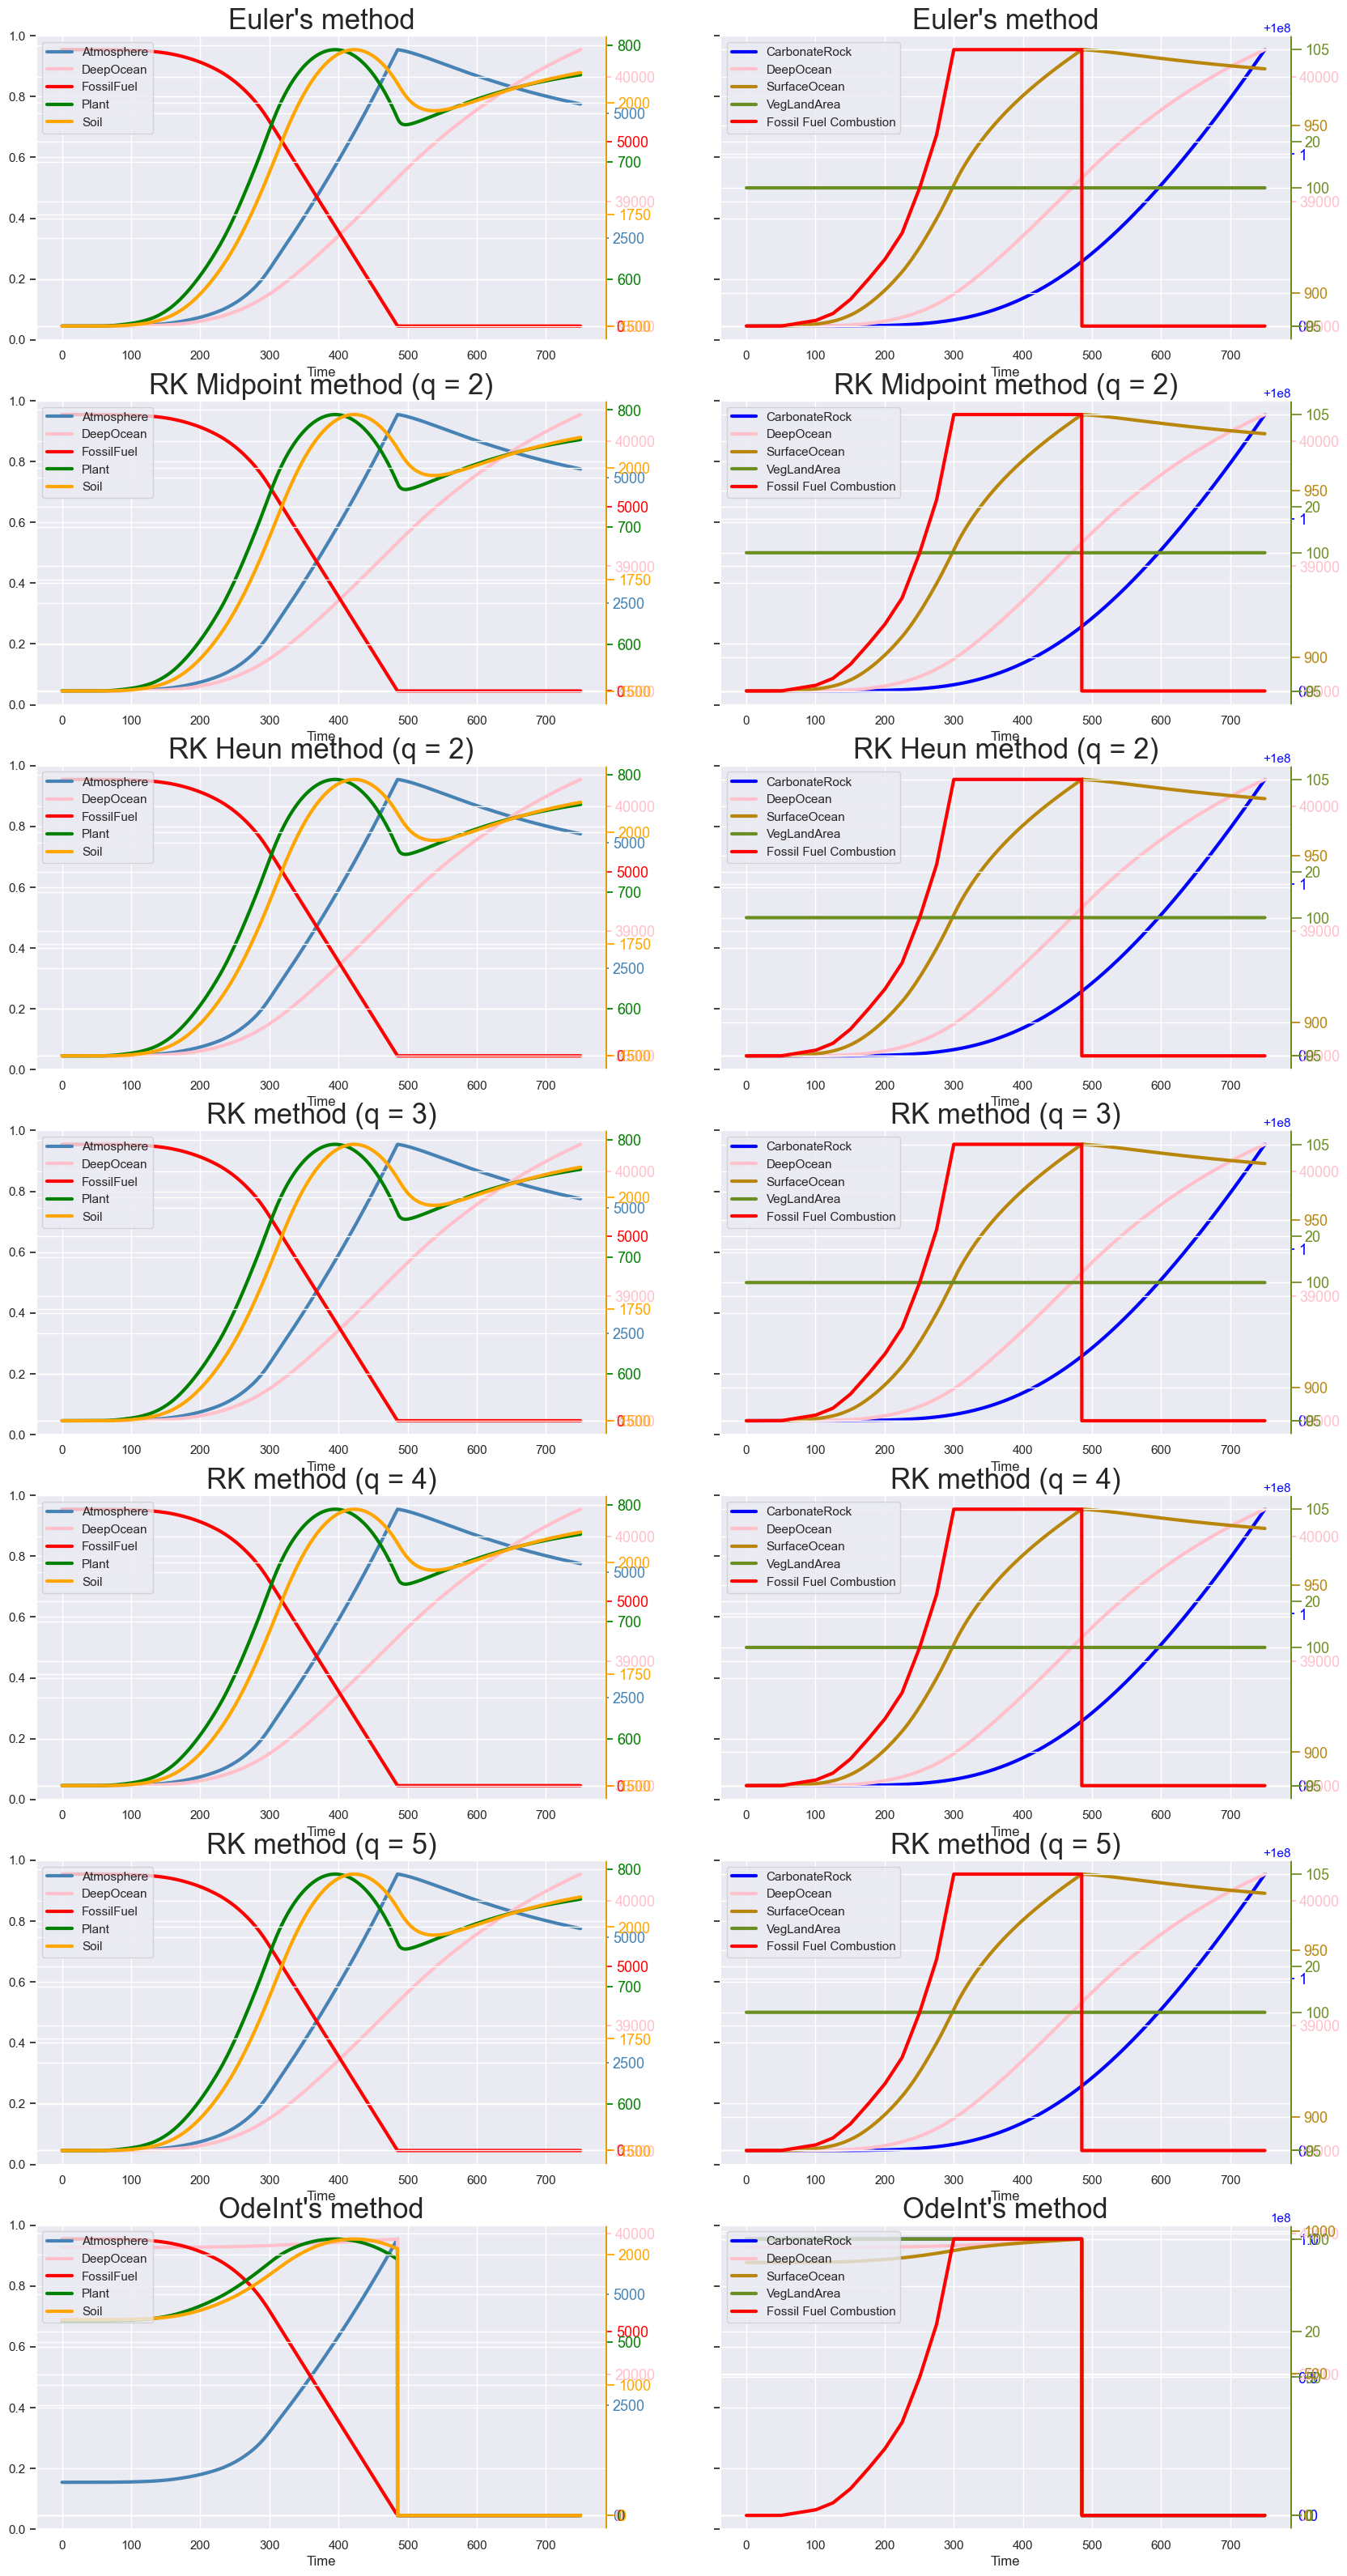

In [12]:

fig, axes = plt.subplots(len(methods), 2, figsize=(20, 40), sharey=True)

# splitting index for plotting
legend = ['Atmosphere', 'CarbonateRock', 'DeepOcean', 'FossilFuel', 
        'Plant', 'Soil', 'SurfaceOcean', 'VegLandArea']
colors = ['steelblue', 'Blue', 'Pink', 'Red', 'Green', 'Orange', 'darkgoldenrod', 'olivedrab', 'Black', 'Yellow']

first_plot_index = [0, 2, 3, 4, 5]
second_plot_index = [1, 2, 6, 7]
indexes = [first_plot_index, second_plot_index]

# going over all the rows
for a in range(len(axes)) :

    # going over each column
    for i in range (len(indexes)) :

        axes[a,i].set_title(method_names[a], size = 25)
        axes[a,i].set_xlabel('Time')
        axes[a,i].grid(True)

        # getting the index to plot for a plot given the column
        line = []
        for index in indexes[i] :
            ax_ = axes[a,i].twinx()
            ax_.plot(time, methods[a][:,index], color = colors[index], linewidth=3)

            # style applied to the right axis
            ax_.spines["right"].set_edgecolor(colors[index])
            ax_.tick_params(axis='y', colors=colors[index], size = index + 2, labelsize = 13)
            ax_.locator_params(axis='y', nbins=3)

            line.append(ax_.get_lines()[0])
            
            # adding all the fossil fuels, combustion to the second column
        if i == 1 :
            ax_ = axes[a,i].twinx()
            ax_.plot(time, allFossilFuelsCombustion[a], color = colors[3], linewidth=3)
            ax_.spines["right"].set_edgecolor(colors[index])
            ax_.tick_params(axis='y', colors=colors[index], size = index + 2, labelsize = 13)
            ax_.locator_params(axis='y', nbins=3)
            line.append(ax_.get_lines()[0])
        ax_.legend(line, [legend[j] for j in indexes[i]] + ['Fossil Fuel Combustion'], loc='upper left')
plt.show()

One may observe that all the methods have a similar result to the one obtained by the modelisation of the website [exchange-system](https://exchange.iseesystems.com/public/globeprogam/global-carbon-cycle-model-with-feedbacks/index.html#page1) except the odeint's method. This one has a problem to compute function that are not smooth, such as ``Atmosphere(t)``. We can see that the errors in the simulation start at the non derivable point of this function.<br><br>
Now, let's go deeper in the result analysis.

## 4. Model Comparison

### 4.a Execution time

Let's take a look at all the computation time of the algorithms.

In [13]:
def compute_exec_time(derivative, x0, t0, T, Nmin, Nmax, step) :
    N_values = np.arange(Nmin, Nmax, step)
    full_exec_time = []
    for N in N_values :
        exec_time = solve_all_methods(derivative, x0, t0, T, N)[3]
        full_exec_time.append(exec_time)
    return N_values, np.array(full_exec_time)

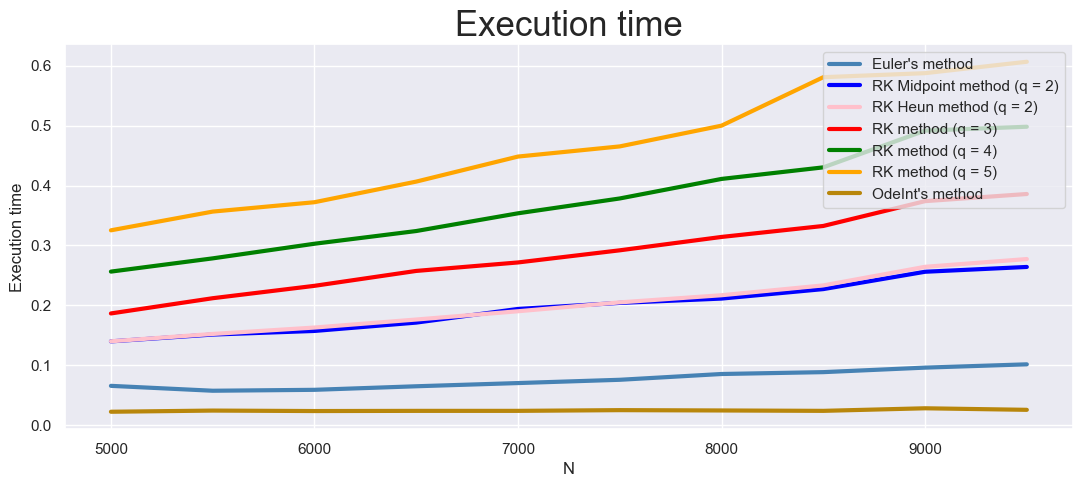

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(13, 5), sharey=True)
axes.set_title('Execution time', size = 25)
axes.set_xlabel('N')
axes.set_ylabel('Execution time')
N_values, full_exec_time = compute_exec_time(derivative, x0, t0, T, 5000, 10000, 500)
line = []
for i in range(full_exec_time.shape[1]) :
    axes.plot(N_values, full_exec_time[:,i], label = method_names[i], linewidth=3, color = colors[i]) 
    line.append(axes.get_lines()[i])
axes.legend(line, method_names, loc='upper right')
plt.show()

As expected, the execution time increases with ``N`` for all methods and with the order of the Runge Kutta's algorithm. This is logical as each step uses more intermediate point to compute the next iteration.<br><br>
One may notice that the odeint's method is particularly fast in comparison with the other methods. It is a very efficient algorithm, but it generalizes less than the other methods, as we have seen above in the non derivable case.

### 4.b Convergence speed of the methods
To evaluate the convergence speed of the algorithms, we take as a reference Runge Kutta's method for q = 4 with an arbitrary high value of iterations ``number_points = 10**5``.

In [15]:
def function_approximation(i, N, n, y):
    prop = i/N
    under = int(prop * n)
    above = under + 1
    prop2 = ((prop * n) - under) / (above - under)
    return y[under] + prop2 * (y[above] - y[under])

def error_calculation(a, N, number_points, method):
    l = []
    func_number = len(a[0])
    for i in range(func_number):
        error = 0
        for j in range(N):
            good_pred = function_approximation(j, N, number_points, method[:,i])
            error += abs((1 - a[j][i]/good_pred))
        l.append(error/N)
    return l


def average_error_euler(N, number_points, method):
    a = euler_method(derivative, x0, t0, T, N)[1]
    return error_calculation(a, N, number_points, method)
    

def average_error_runge_kutta_four(N, number_points, method):
    a = runge_kutta_four(derivative, x0, t0, T, N)[1]
    return error_calculation(a, N, number_points, method)

def average_error_runge_kutta_two_mid_point(N, number_points, method):
    a = runge_kutta_two(derivative, x0, t0, T, N, alpha=1/2, beta=1)[1]
    return error_calculation(a, N, number_points, method)

def average_error_runge_kutta_two_heuns(N, number_points, method):
    a = runge_kutta_two(derivative, x0, t0, T, N, alpha=1, beta=1/2)[1]
    return error_calculation(a, N, number_points, method)

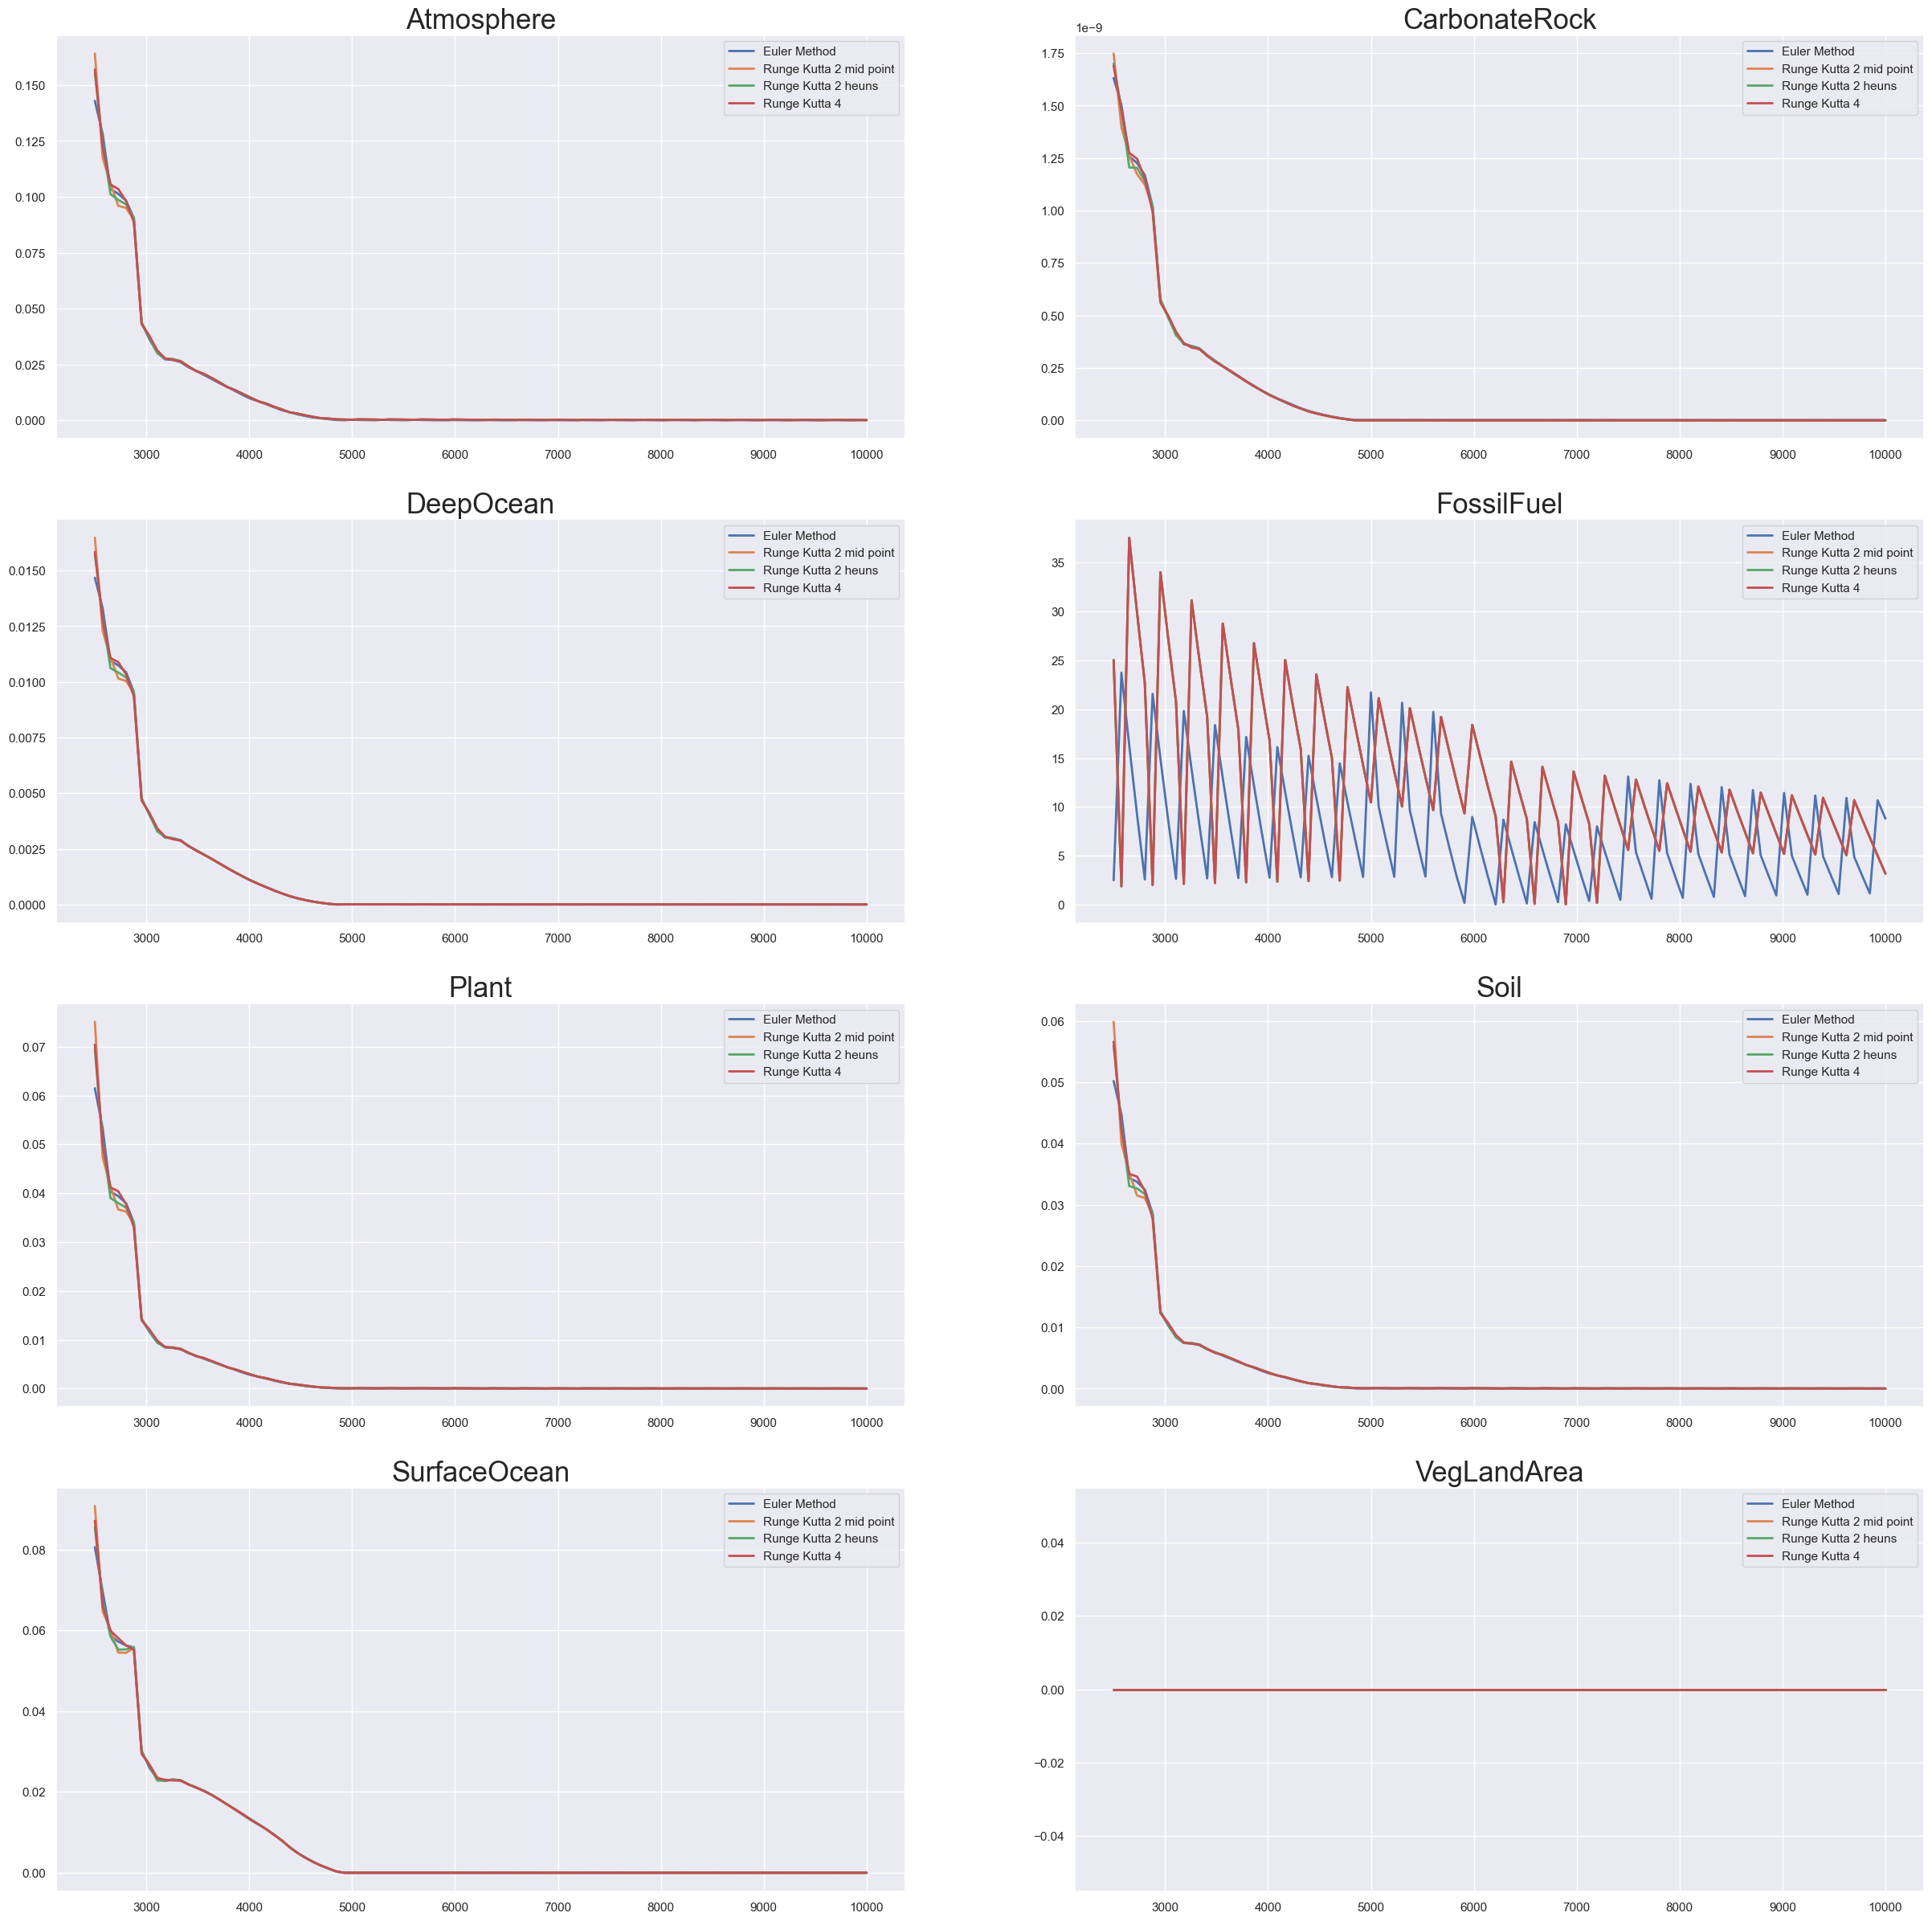

In [16]:
# computing the reference method
number_points = 10**5
y_rk_four_asymptotic = runge_kutta_four(derivative, x0, t0, T, number_points)[1]

l1 = []
l2 = []
l3 = []
l4 = []

fig, ax = plt.subplots(4, 2, figsize=(30, 30))

n = np.linspace(2500, 10_000, 100)
c = 0

for i in n:
    l1.append(average_error_euler(int(i), number_points, y_rk_four_asymptotic))
    l2.append(average_error_runge_kutta_two_mid_point(int(i), number_points, y_rk_four_asymptotic))
    l3.append(average_error_runge_kutta_two_heuns(int(i), number_points, y_rk_four_asymptotic))
    l4.append(average_error_runge_kutta_four(int(i), number_points, y_rk_four_asymptotic))
    c+=1


ax[0][0].set_title('Atmosphere', size = 25)
ax[0][1].set_title('CarbonateRock', size = 25)
ax[1][0].set_title('DeepOcean', size = 25)
ax[1][1].set_title('FossilFuel', size = 25)
ax[2][0].set_title('Plant', size = 25)
ax[2][1].set_title('Soil', size = 25)
ax[3][0].set_title('SurfaceOcean', size = 25)
ax[3][1].set_title('VegLandArea', size = 25)


ax[0][0].plot(n, [sous_liste[0] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[0][0].plot(n, [sous_liste[0] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[0][0].plot(n, [sous_liste[0] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[0][0].plot(n, [sous_liste[0] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[0][0].legend()

ax[0][1].plot(n, [sous_liste[1] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[0][1].plot(n, [sous_liste[1] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[0][1].plot(n, [sous_liste[1] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[0][1].plot(n, [sous_liste[1] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[0][1].legend()

ax[1][0].plot(n, [sous_liste[2] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[1][0].plot(n, [sous_liste[2] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[1][0].plot(n, [sous_liste[2] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[1][0].plot(n, [sous_liste[2] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[1][0].legend()

ax[1][1].plot(n, [sous_liste[3] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[1][1].plot(n, [sous_liste[3] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[1][1].plot(n, [sous_liste[3] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[1][1].plot(n, [sous_liste[3] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[1][1].legend()

ax[2][0].plot(n, [sous_liste[4] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[2][0].plot(n, [sous_liste[4] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[2][0].plot(n, [sous_liste[4] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[2][0].plot(n, [sous_liste[4] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[2][0].legend()

ax[2][1].plot(n, [sous_liste[5] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[2][1].plot(n, [sous_liste[5] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[2][1].plot(n, [sous_liste[5] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[2][1].plot(n, [sous_liste[5] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[2][1].legend()

ax[3][0].plot(n, [sous_liste[6] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[3][0].plot(n, [sous_liste[6] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[3][0].plot(n, [sous_liste[6] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[3][0].plot(n, [sous_liste[6] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[3][0].legend()

ax[3][1].plot(n, [sous_liste[7] for sous_liste in l1], label = 'Euler Method', linewidth = 2)
ax[3][1].plot(n, [sous_liste[7] for sous_liste in l2], label = 'Runge Kutta 2 mid point', linewidth = 2)
ax[3][1].plot(n, [sous_liste[7] for sous_liste in l3], label = 'Runge Kutta 2 heuns', linewidth = 2)
ax[3][1].plot(n, [sous_liste[7] for sous_liste in l4], label = 'Runge Kutta 4', linewidth = 2)
ax[3][1].legend()

plt.show()
fig.suptitle('Average Error')

plt.show()

All the algorithms have similar precision functions for all the graphs. Starting from ``N = 5000``, it is almost impossible to differentiate them and their computed error is satisfying.
The ``Fossil Fuel`` error function is the exception. The error function is particularly high and oscillates. It still tends to tend to zero, but slower.

## Conclusion

Odeint does not provide satisfying results. The irregularities of the function lead to outliers.
Runge Kutta methods are a lot better and starting from ``N = 5000`` (approximately), the error of the methods are close to each other and close to zero.

To have the best running time, one may take the Euler method, as it is very efficient.